# Multiclass Classification using MNIST Dataset

## Import Dependencies

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from time import time
import numpy as np
import random
import matplotlib.pyplot as plt
from keras.datasets import mnist

## Set Random seed

In [2]:
np.random.seed(0)
torch.manual_seed(0)
random.seed(0)

## Set device

In [3]:
def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

## Arguments regarding data, model and training

In [4]:
N = 512
epochs = 25
iters = 150
learning_rate = 0.001
# Minibatch size
bsz = 128
device = set_device()

GPU is enabled in this notebook.


## Download MNIST Data

In [5]:
def mnist_data(frac=False):
  idx = np.arange(60000)
  np.random.shuffle(idx)
  (x_train, y_train), (x_test, y_test) = mnist.load_data()
  X_train = np.reshape(x_train, [-1, 784])
  X_test = np.reshape(x_test, [-1, 784])

  if frac:
    return X_train[idx[:10000], :128], y_train[idx[:10000]], X_test[:, 128], y_test, 10, 128
  else:
    return X_train, y_train, X_test, y_test, 10, 784

In [6]:
X_train, y_train, X_val, y_val, nc, d = mnist_data()

X_train = torch.Tensor(X_train)
y_train = torch.Tensor(y_train)
X_val = torch.Tensor(X_val)
y_val = torch.Tensor(y_val)
print(X_train.shape)
print(y_train.shape)

11501568/11490434 [==============================] - 0s 0us/step
torch.Size([60000, 784])
torch.Size([60000])


## Visualize Data

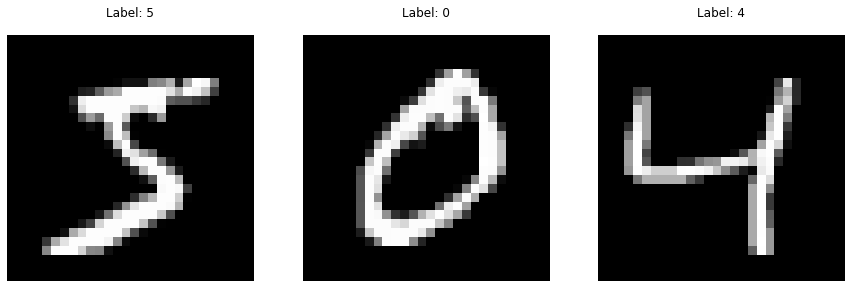

In [7]:
num_figures = 3
fig, axs = plt.subplots(1, num_figures, figsize=(5 * num_figures, 5))

for sample_id, ax in enumerate(axs):
  # Plot the pixel values for each image
  ax.matshow(X_train[sample_id, :].reshape(28,28), cmap='gray')

  ax.set_title('Label: ' + str(y_train[sample_id].long().item()))
  ax.axis('off')

plt.show()

## Helper functions

In [8]:
def minibatch(X, y, num_points):
  """
  Sample a minibatch of size num_point from the provided input-target data

  Args:
    X: Tensor
      Multi-dimensional tensor containing the input data
    y: Tensor
      1D tensor containing the ground truth
    num_points: Integer
      Number of elements to be included in minibatch

  Returns:
    batch_x: Tensor
      Minibatch inputs
    batch_y: Tensor
      Minibatch targets
  """
  # Sample a collection of IID indices from the existing data
  batch_indices = np.random.choice(len(X), num_points)
  # Use batch_indices to extract entries from the input and target data tensors
  batch_x = X[batch_indices]
  batch_y = y[batch_indices]

  return batch_x, batch_y

In [9]:
def accuracy(pred, y):
 
  # Function to calculate the accuracy of model predictions
 
  a = torch.eq(pred, y.long()).double().mean() * 100

  return a

# Classification using MLP

In [10]:
class MLP(nn.Module):
  """
   A neural network with a single hidden layer
  """
  
  def __init__(self, input_size, hidden_size, output_size):
    """
    Initializing the parameters of MLP

    Args:
      input_size: Int
        Number of input features (784)
      hidden_size: List
        Containing the dimensions of the hidden layers
      output_size: Int
        Number of output classes (10)

    Returns:
      Nothing
    """
    super(MLP, self).__init__()
    self.layers = nn.Sequential(
        nn.Linear(input_size, hidden_size[0]),
        nn.ReLU(),
        nn.Linear(hidden_size[0], hidden_size[1]),
        nn.ReLU(),
        nn.Linear(hidden_size[1], hidden_size[2]),
        nn.ReLU(),
        nn.Linear(hidden_size[2], output_size)
    )

  def forward(self, x):
    """
    Forward pass

    Args:
      x: torch.Tensor
        D-dimensional tensor of features

    Returns:
      Torch tensor of model predictions
    """

    return self.layers(x)

In [11]:
# Creating an instance
mlp = MLP(input_size = X_train.shape[1], hidden_size = [200, 100, 50], output_size = nc).to(device)
# Adam optimizer
adam_optimizer = torch.optim.Adam(mlp.parameters(), lr= learning_rate)
# Create a cross entropy loss function
criterion = nn.CrossEntropyLoss()

In [12]:
def train(X, y, model, criterion, optimizer, iters, bsz):
  """
  Training function

  Args:
    X: torch.Tensor
      Features (input) with shape torch.Size([N, d])
    y: torch.Tensor
      Labels (targets) with shape torch.Size([N, nc])
    model: torch nn.Module
      The neural network
    criterion: function
      Loss function
    optimizer: function
      Optimizer
    iters: int
      Number of training iterations
    bsz: int
      Number of elements in the minibatch

  Returns:
    avg_loss: float
      Average loss over all iters
    acc: float
      Average training accuracy over all iters
  """
  model.train()  
  X = X.to(device)
  y = y.to(device)

  loss_record = [] # Keeping records of loss
  acc_record = [] # Keeping records of accuracy
  
  for i in range(iters):
    
    # Extract minibatch data and labels
    batch_X, batch_y = minibatch(X, y, bsz)
    
    # Reset all gradients to zero
    optimizer.zero_grad()
    
    # Forward pass (Compute the output of the model on the features (inputs))
    y_pred = model(batch_X)
    
    # Compute the loss
    loss = criterion(y_pred, batch_y.long())
    
    # Perform backpropagation and compute the gradients
    loss.backward()

    # Optimizer takes a tiny step in the steepest direction (negative of gradient) and "updates" the weights and biases of the network
    optimizer.step()

    loss_record.append(loss.item())
    acc_record.append(accuracy(torch.argmax(y_pred, dim=1), batch_y).item())

  # Compute average loss over all iterations
  avg_loss = np.sum(loss_record) / iters
  avg_acc = np.sum(acc_record) / iters

  return avg_loss, avg_acc

def eval(X, y, model, criterion):
  """
  Function to gauge network performance

  Args:
    X: torch.tensor
      Features (input) with shape torch.Size([N, d])
    y: torch.tensor
      Labels (targets) with shape torch.Size([N, nc])
    model: torch nn.Module
      The neural network
    criterion: function
      Loss function

  Returns:
    eval_loss: float 
      Scalar loss value over (X, y) using the model 
    eval_acc: float
      Validation accuracy 
  """

  model.eval()

  with torch.no_grad():
    X = X.to(device)
    y = y.to(device)
    y_pred = model(X)
  
    eval_loss = criterion(y_pred, y.long()).item()
  
    # Compute accuracy
    eval_acc = accuracy(torch.argmax(y_pred,dim=1), y)

  return eval_loss, eval_acc

In [13]:
def main(model, optimizer, criterion, epochs, iters, X_train, X_val, y_train, y_val, bsz):
  """
  Train the model and tests the learned model
    
    Args:
      model: torch nn.Module
        The neural network
      optimizer: function
        optimizer
      criterion: function
        Loss function
      epochs: int
        number of training and validation iterations
      iters: int
        Number of training iterations
      X_train: torch.Tensor
        Training features (input) with shape torch.Size([N, d])
      X_val: torch.Tensor
        Validation features (input) with shape torch.Size([N, d])
      y_train: torch.tensor
        Training labels (targets) with shape torch.Size([N, 1])
      y_val: torch.tensor
        Validation labels (targets) with shape torch.Size([N, 1])
      bsz: int
        Number of elements in the minibatch

    Returns:
      Nothing
  """
  for i in range(epochs):
    losses, train_acc = train(X_train, y_train, model, criterion, optimizer, iters, bsz)
    val_loss, val_acc = eval(X_val, y_val, model, criterion)
    if i % 5 == 0 or i == epochs - 1:
      print(f'Epoch: {i} train loss: {losses:.2f} Validation loss: {val_loss:.2f} train accuracy: {train_acc:.2f} validation accuracy: {val_acc:.2f}')

In [14]:
main(mlp, adam_optimizer, criterion, epochs, iters, X_train, X_val, y_train, y_val, bsz)

Epoch: 0 train loss: 0.47 Validation loss: 0.24 train accuracy: 87.01 validation accuracy: 93.12
Epoch: 5 train loss: 0.10 Validation loss: 0.14 train accuracy: 96.96 validation accuracy: 96.07
Epoch: 10 train loss: 0.07 Validation loss: 0.13 train accuracy: 97.88 validation accuracy: 96.28
Epoch: 15 train loss: 0.05 Validation loss: 0.14 train accuracy: 98.18 validation accuracy: 96.47
Epoch: 20 train loss: 0.05 Validation loss: 0.11 train accuracy: 98.61 validation accuracy: 97.17
Epoch: 24 train loss: 0.04 Validation loss: 0.14 train accuracy: 98.64 validation accuracy: 96.53


# Classification using Logistic Regression

In [15]:
class LogisticReg(nn.Module):
 
  # A single layer neural network
 
  def __init__(self, input_size, output_size):

    """
    Initializing the parameters of the network

    Args:
      input_size: Int
        Number of input features
      output_size: Int
        Number of output features

    Returns:
      Nothing
    """
    super(LogisticReg, self).__init__()
    self.layers = nn.Sequential(
        nn.Linear(input_size, output_size)
    )

  def forward(self, x):
    """
    Forward pass

    Args:
      x: torch.Tensor
        D-dimensional tensor of features

    Returns:
      Torch tensor of model predictions
    """

    return self.layers(x)

In [16]:
# Creating an instance
net = LogisticReg(input_size = X_train.shape[1], output_size = nc).to(device)
# Create a cross entropy loss function
criterion = nn.CrossEntropyLoss()
# Adam optimizer
adam_optimizer = torch.optim.Adam(net.parameters(), lr= learning_rate)

In [17]:
# Main loop
main(net, adam_optimizer, criterion, epochs, iters, X_train, X_val, y_train, y_val, bsz)

Epoch: 0 train loss: 6.84 Validation loss: 3.38 train accuracy: 78.98 validation accuracy: 86.40
Epoch: 5 train loss: 2.47 Validation loss: 2.51 train accuracy: 88.19 validation accuracy: 88.89
Epoch: 10 train loss: 2.27 Validation loss: 2.58 train accuracy: 89.23 validation accuracy: 88.55
Epoch: 15 train loss: 2.31 Validation loss: 2.64 train accuracy: 89.02 validation accuracy: 89.21
Epoch: 20 train loss: 2.29 Validation loss: 3.28 train accuracy: 89.25 validation accuracy: 86.54
Epoch: 24 train loss: 2.15 Validation loss: 2.97 train accuracy: 89.77 validation accuracy: 88.34


# Convolutional Neural Network (CNN)

In [18]:
class CNN(nn.Module):
  """
  Convolutional Neural Network model
  """

  def __init__(self):
    """
    Initialise parameters of CNN

    Args:
      Nothing

    Returns:
      Nothing
    """
    
    super(CNN, self).__init__()

    self.layers = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        nn.AdaptiveAvgPool2d((1,1)),
        nn.Flatten(),
        nn.Linear(in_features=64, out_features=128),
        nn.ReLU(),
        nn.Linear(in_features=128, out_features=10)
    )

  def forward(self, x):
    """
    Forward pass of CNN

    Args:
      x: torch.tensor
        Input features

    Returns:
      x: torch.tensor
        Output after passing through CNN
    """
    return self.layers(x)

  def layer_summary(self, X_shape, device):
    """
    Prints the output shape at each layer

    Args:
      X_shape: torch.tensor
        Shape of X_train
      device: string
        GPU/CUDA if available, CPU otherwise
    """
    X=torch.randn(*X_shape).to(device)
    for layer in self.layers:
      X=layer(X)
      print(layer.__class__.__name__,'output shape:\t', X.shape)

In [19]:
# Create an instance of the model
cnn = CNN().to(device)
# Output of each layer
cnn.layer_summary((128,1,28,28), device)
# Adam optimizer
adam_optimizer = torch.optim.Adam(cnn.parameters(), lr= learning_rate)
# Create a cross entropy loss function
criterion = nn.CrossEntropyLoss()

Conv2d output shape:	 torch.Size([128, 32, 26, 26])
ReLU output shape:	 torch.Size([128, 32, 26, 26])
MaxPool2d output shape:	 torch.Size([128, 32, 13, 13])
Conv2d output shape:	 torch.Size([128, 64, 11, 11])
ReLU output shape:	 torch.Size([128, 64, 11, 11])
MaxPool2d output shape:	 torch.Size([128, 64, 5, 5])
AdaptiveAvgPool2d output shape:	 torch.Size([128, 64, 1, 1])
Flatten output shape:	 torch.Size([128, 64])
Linear output shape:	 torch.Size([128, 128])
ReLU output shape:	 torch.Size([128, 128])
Linear output shape:	 torch.Size([128, 10])


In [20]:
# Main loop
main(cnn, adam_optimizer, criterion, epochs, iters, X_train.reshape(-1, 1, 28, 28), X_val.reshape(-1, 1, 28, 28), y_train, y_val, bsz)

Epoch: 0 train loss: 1.63 Validation loss: 0.54 train accuracy: 55.62 validation accuracy: 85.58
Epoch: 5 train loss: 0.17 Validation loss: 0.18 train accuracy: 94.80 validation accuracy: 94.46
Epoch: 10 train loss: 0.12 Validation loss: 0.11 train accuracy: 96.24 validation accuracy: 96.52
Epoch: 15 train loss: 0.11 Validation loss: 0.13 train accuracy: 96.59 validation accuracy: 95.79
Epoch: 20 train loss: 0.09 Validation loss: 0.09 train accuracy: 97.01 validation accuracy: 97.36
Epoch: 24 train loss: 0.06 Validation loss: 0.07 train accuracy: 98.21 validation accuracy: 97.64
